Using TensorFlow backend.


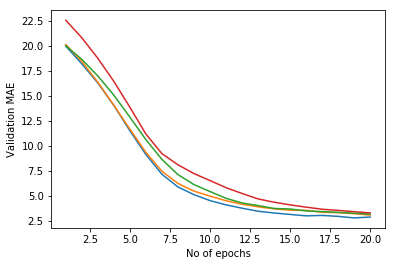

In [1]:
from keras import models, layers
from matplotlib import pyplot as plt
from keras.datasets import boston_housing
import numpy as np
%matplotlib inline
# Make and train a model on train_data / train_targets, for num_epochs.
# Assume train_data has 2-D shape (a set of 1-D vectors) and train_targets
# has 1-D shape (a set of numerical values)

def build_and_train_model(train_data, train_targets, val_data, val_targets, num_epochs, batch_size):
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))  # Linear activation to get unskewed num range
  
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    history = model.fit(train_data, train_targets, 
     validation_data = (val_data, val_targets),
     epochs=num_epochs, batch_size=batch_size, verbose = 0)
     
    return (model, history.history['val_mean_absolute_error'])

def fold_test(train_data, train_targets, num_folds, num_epochs):
    num_samples = train_data.shape[0]
    val_size = num_samples // num_folds
    batch_size = (num_samples - val_size) // 500 # Up to 500 batches, ....
    batch_size = max(32, batch_size)             # but at least 32 samples, ...
    batch_size = min(num_samples, batch_size)    # and no more than num_samples
    mae_per_fold = []
    
    # Repeat test for each fold
    for fold in range(num_folds):
        val_data = train_data[fold*val_size : (fold+1)*val_size]
        val_targets = train_targets[fold*val_size : (fold+1)*val_size]
        
        partial_train_data = np.concatenate(
           [train_data[ :fold*val_size], train_data[(fold+1)*val_size: ]],
           axis=0      # Concatenate along sample axis
        )
        
        partial_train_targets = np.concatenate(
           [train_targets[ :fold*val_size], train_targets[(fold+1)*val_size: ]],
           axis=0      # Concatenate along sample axis
        )

        model, history = build_and_train_model(partial_train_data, partial_train_targets,
         val_data, val_targets, num_epochs, batch_size)
        
        # model.evaluate(val_data, val_targets, verbose=0)
        # print(model.metrics_names, mse, mae)
        
        mae_per_fold.append(history)
        
    return mae_per_fold
        
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()
 
#print(train_data[0])
#print(train_targets[0])
#exit()

mean = train_data.mean(axis=0)      # Average corresponding values across sample axis
train_data -= mean                  # Shift so average is zero

std = train_data.std(axis=0)     
train_data /= std                   # Scale so std = 1

test_data = (test_data - mean)/std  # Test data uses train data parameters

# print(train_data[0])
# print(train_targets[0])
# exit()

mae_per_fold = fold_test(train_data, train_targets, 4, 20)

# print(mae_per_fold)

for history in mae_per_fold:
    plt.plot(range(1, len(history)+1), history)

plt.xlabel('No of epochs')
plt.ylabel('Validation MAE')
plt.show()